In [1]:
# magic
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # fix scaling issues

In [2]:
# import packages
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

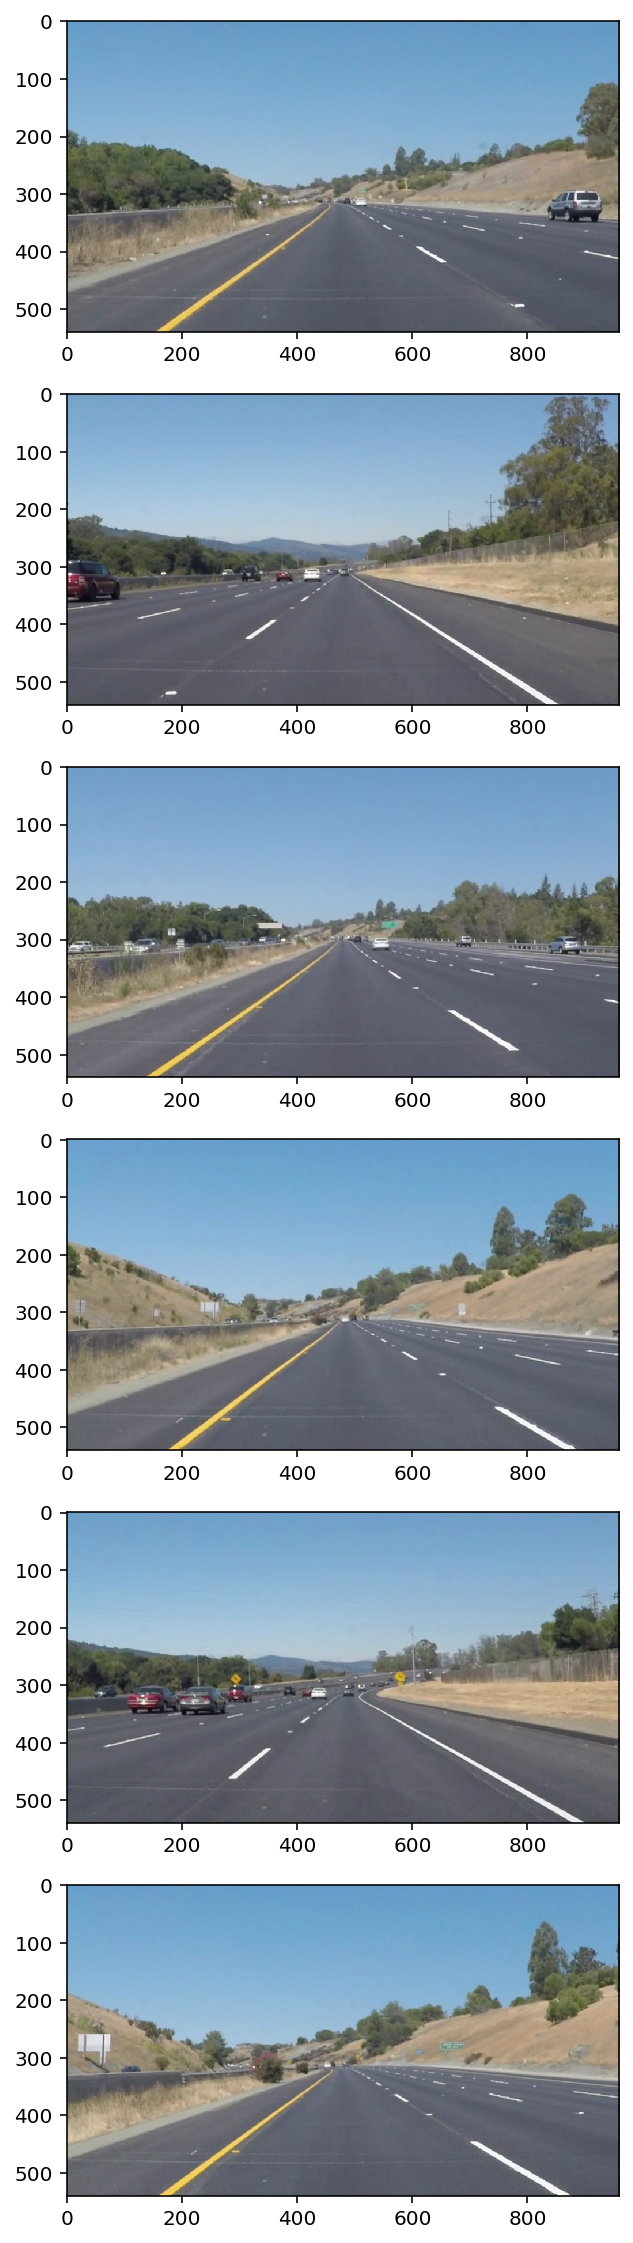

In [3]:
# import data
input_files = os.listdir('test_images/')
images = []
for x in input_files:
    tmp = mpimg.imread('test_images/' + x)
    images.append(tmp)
num_images = len(images)

# plot results

fig, axes = plt.subplots(num_images,1,figsize=(20,20))

for i in np.arange(num_images):
    axes[i].imshow(images[i])

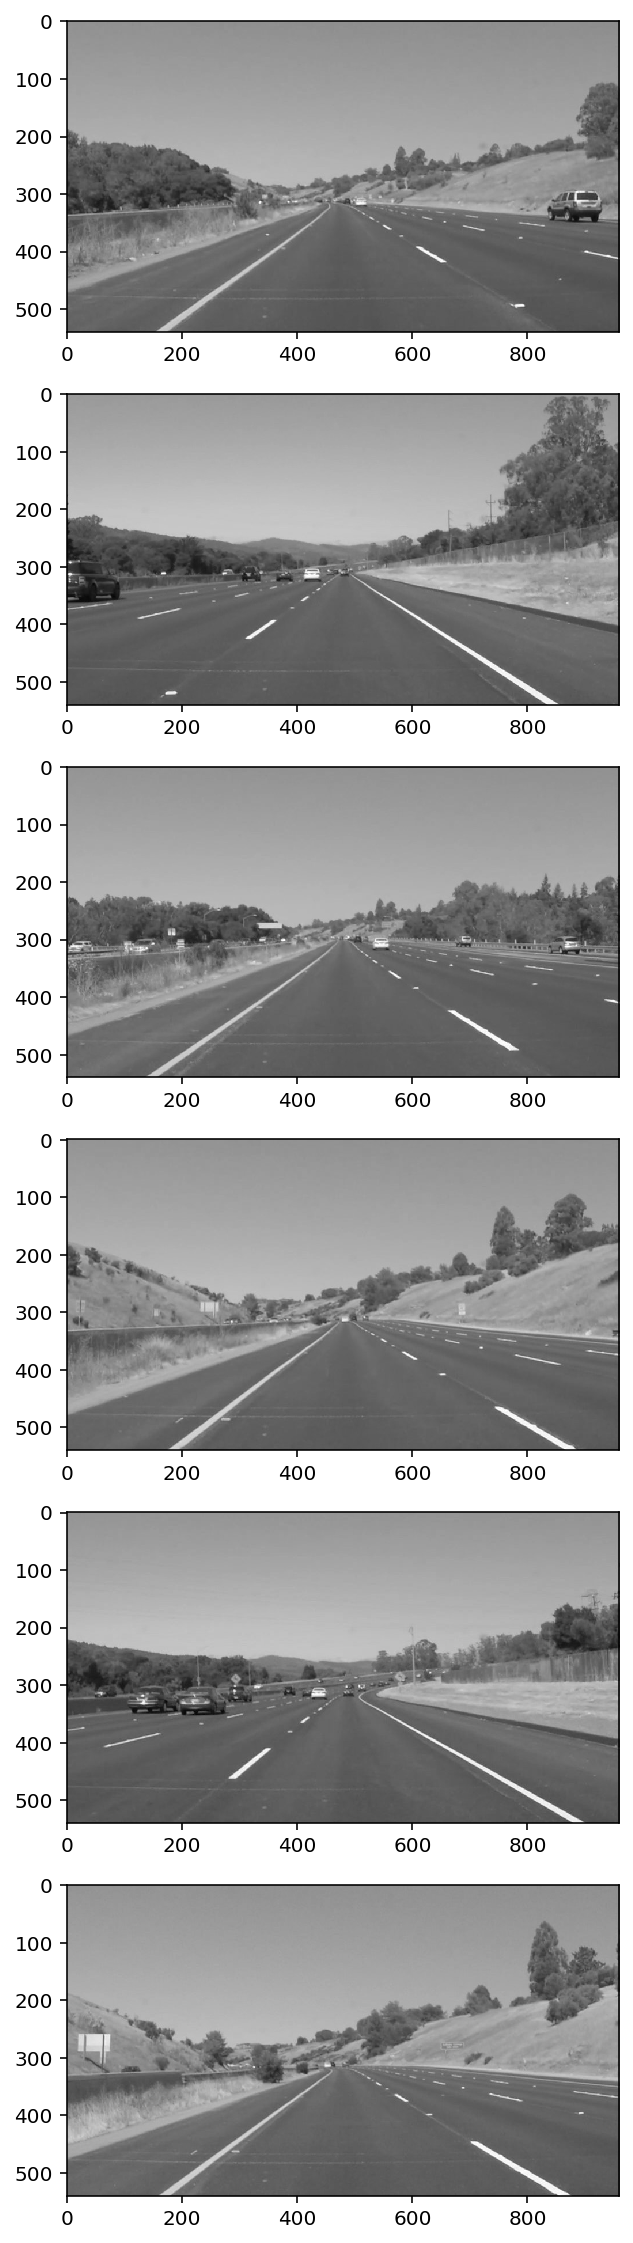

In [4]:
# convert to grayscale
grayscales = []
for i in np.arange(num_images):
    tmp = cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY)
    graystack = np.dstack((tmp, tmp, tmp))
    grayscales.append(graystack)
    
# plot results

fig, axes = plt.subplots(num_images,1,figsize=(20,20))

for i in np.arange(num_images):
    axes[i].imshow(grayscales[i])

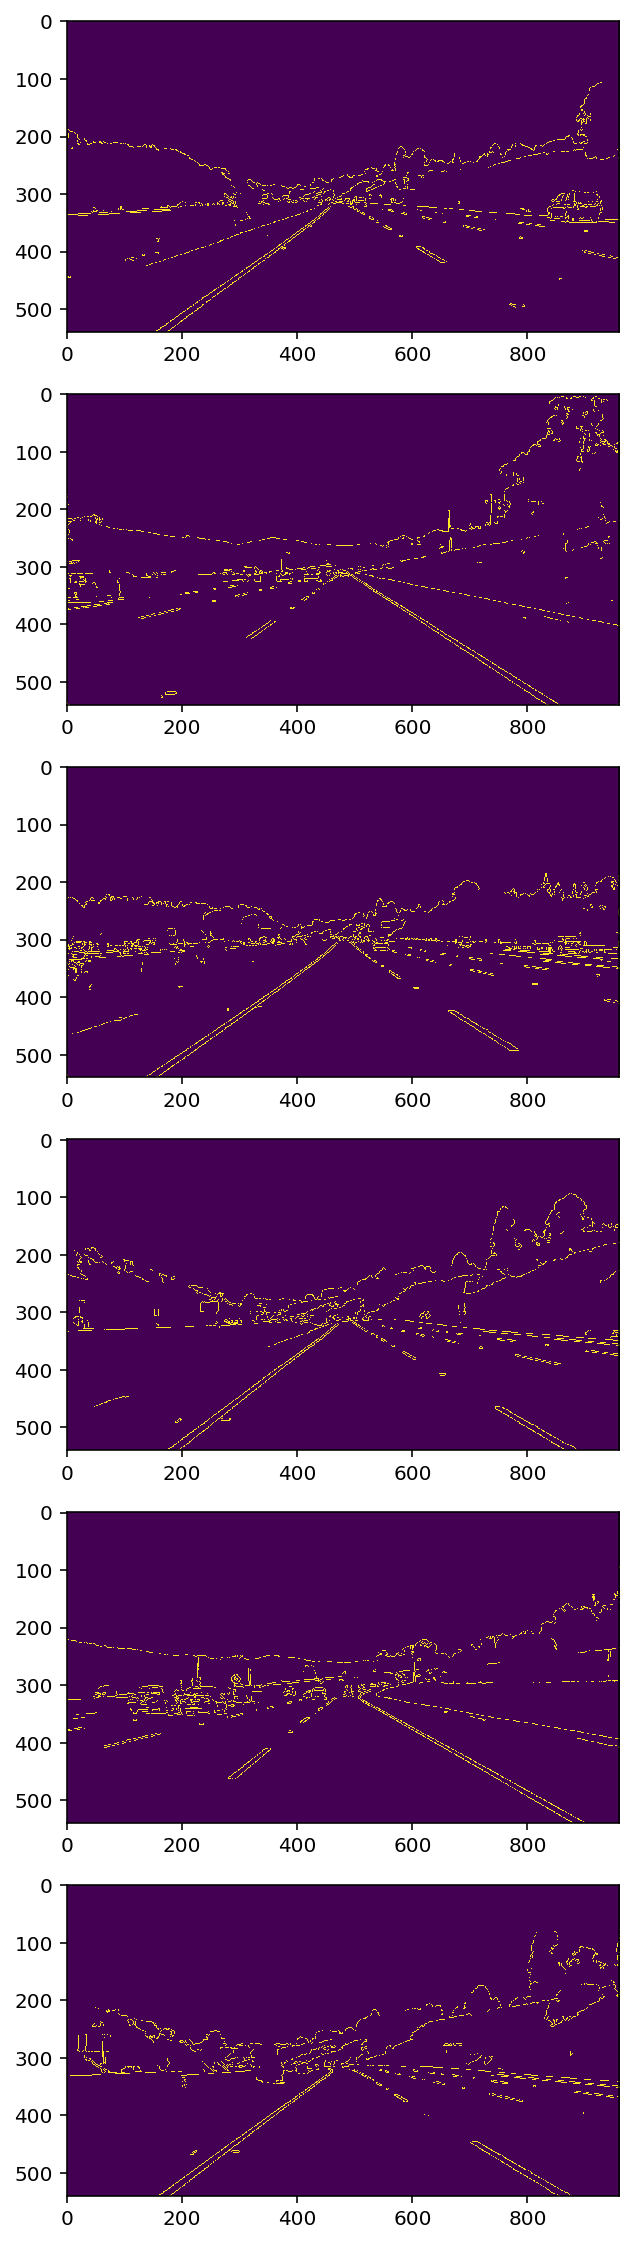

In [5]:
# Canny edge detection
cannys = []
for i in np.arange(num_images):
    low_threshold = 100
    high_threshold = 200
    canny = cv2.Canny(grayscales[i], low_threshold, high_threshold)
    cannys.append(canny)

# plot results

fig, axes = plt.subplots(num_images,1,figsize=(20,20))

for i in np.arange(num_images):
    axes[i].imshow(cannys[i])

/home/vagrant/anaconda3/envs/udacity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/vagrant/anaconda3/envs/udacity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/vagrant/anaconda3/envs/udacity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/vagrant/anaconda3/envs/udacity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/vagrant/anaconda3/envs/udacity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns,

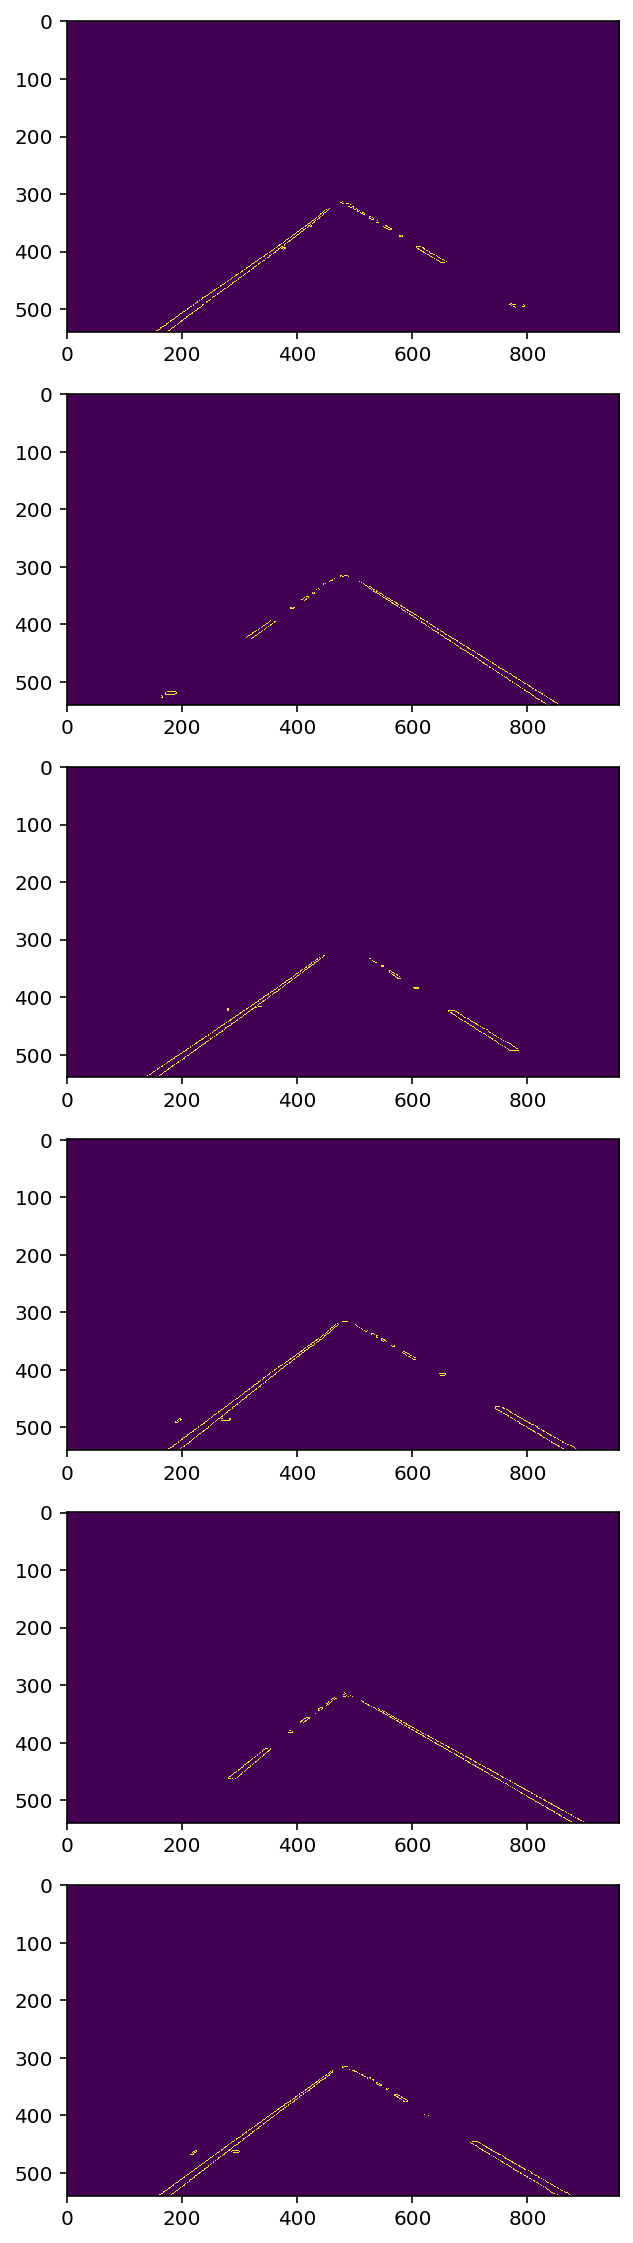

In [6]:
# Region masking

masked_cannys = []

for i in np.arange(num_images):
    masked_canny = np.copy(cannys[i])

    # get image dimensions
    xsize = graystack.shape[1]
    ysize = graystack.shape[0]

    # set mask corners
    TL = (int(xsize/2), int(ysize/1.73))
    TR = (int(xsize/2), int(ysize/1.73))
    BL = (0, ysize)
    BR = (xsize, ysize)

    # calculate mask lines
    left = np.polyfit((BL[0], TL[0]), (BL[1], TL[1]), 1)
    right = np.polyfit((TR[0], BR[0]), (TR[1], BR[1]), 1)
    top = np.polyfit((TL[0], TR[0]), (TL[1], TR[1]), 1)
    bottom = np.polyfit((BL[0], BR[0]), (BL[1], BR[1]), 1)

    # create meshgrid
    XX,YY = np.meshgrid((np.arange(0,xsize)), np.arange(0,ysize))

    # populate meshgrid
    region_mask = (YY > (top[0] * XX + top[1])) & \
                   (YY > (right[0] * XX + right[1])) & \
                   (YY > (left[0] * XX + left[1])) & \
                   (YY < (bottom[0] * XX + bottom[1]))

    # mask image
    masked_canny[~region_mask] = 0
    masked_cannys.append(masked_canny)
    
# plot results

fig, axes = plt.subplots(num_images,1,figsize=(20,20))

for i in np.arange(num_images):
    axes[i].imshow(masked_cannys[i])

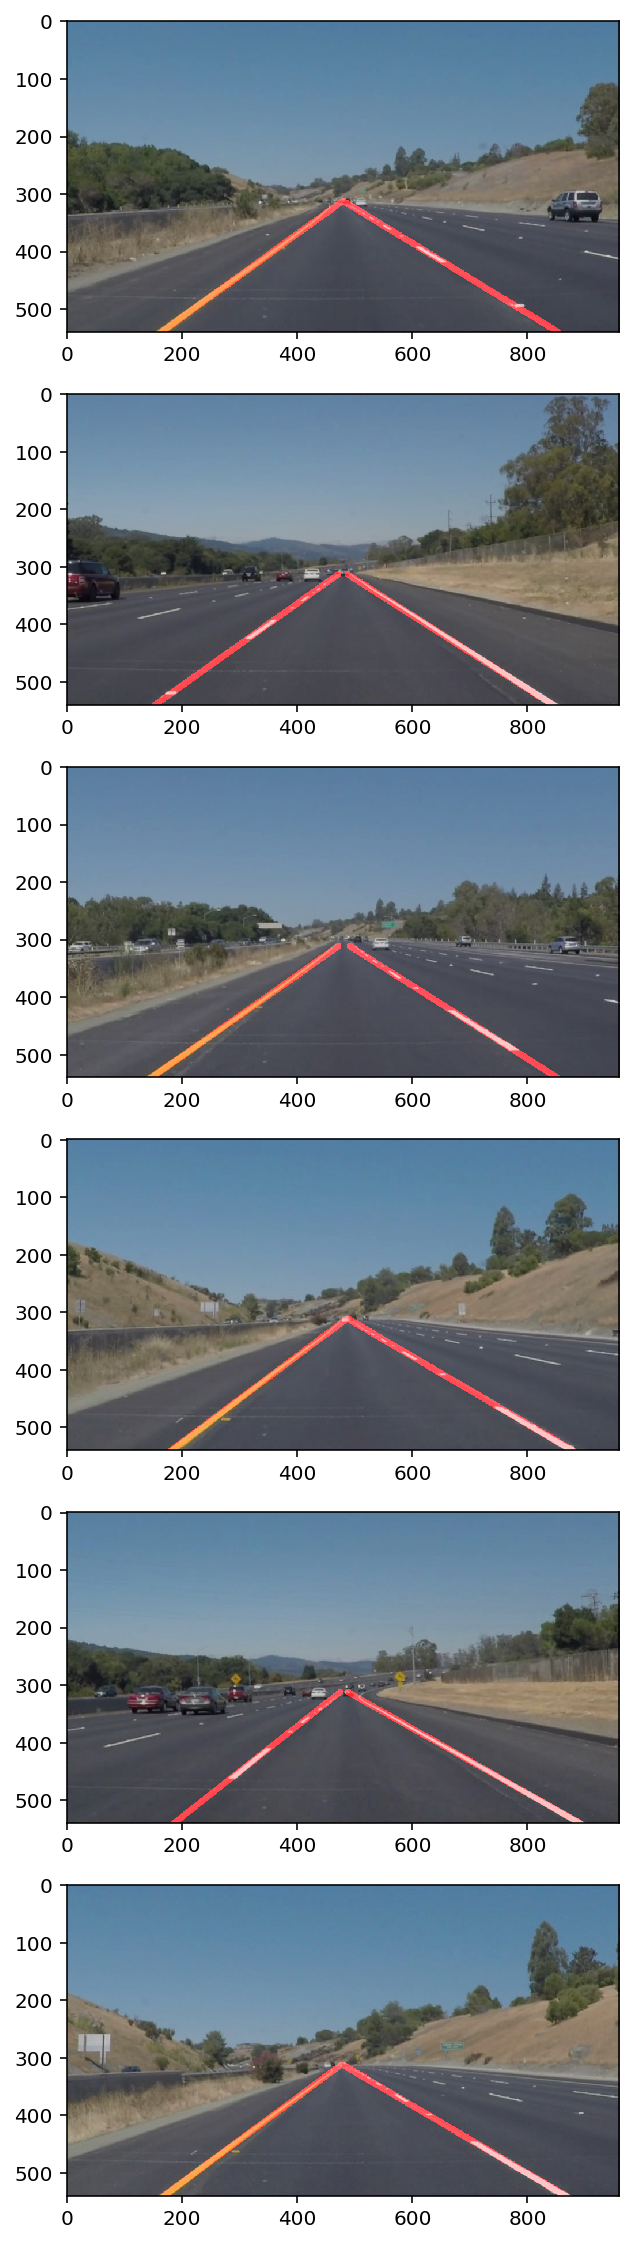

In [7]:
# Line detection

combos = []

for i in np.arange(num_images):
    combo = np.copy(images[i])

    # set parameters
    rho = 1
    theta = np.pi/180
    threshold = 25
    max_line_gap = 200
    min_line_length = 50

    line_image = np.copy(graystack)*0

    lines = cv2.HoughLinesP(masked_cannys[i], rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # accumulator values (for smoothing)
    
    leftx_acc = 0
    lefty_acc = 0
    left_slope = 0
    left_x_av = 0
    left_y_av = 0
    num_lines_left = 0
    
    rightx_acc = 0
    righty_acc = 0
    right_slope = 0
    right_x_av = 0
    right_y_av = 0
    num_lines_right = 0
    
    for line in lines:
        for x1,y1,x2,y2 in line:

            # push to accumulators
            if y2 < y1:
                leftx_acc += (x2 - x1)
                lefty_acc += (y2 - y1)
                left_x_av += x1
                left_y_av += y1
                num_lines_left += 1
            else:
                rightx_acc += (x2 - x1)
                righty_acc += (y2 - y1)
                right_x_av += x1
                right_y_av += y1
                num_lines_right += 1
    
    # calculate derivative
    left_slope = lefty_acc / leftx_acc
    right_slope = righty_acc / rightx_acc
    
    # find average x,y to calculate b
    left_x_av /= num_lines_left
    left_y_av /= num_lines_left
    right_x_av /= num_lines_right
    right_y_av /= num_lines_right
    
    # y = m*x + b -> b = y - m * x
    left_b = left_y_av - left_slope * left_x_av
    right_b = right_y_av - right_slope * right_x_av
    
    # for left line, solve for y1 = ysize
    # y1 = m * x1 + b -> x1 = (y1 - b) / m
    y1_left = ysize
    x1_left = int((y1_left - left_b) / left_slope)
    # solve for y2 = TL[1]
    y2_left = TL[1]
    x2_left = int((y2_left - left_b) / left_slope)
    
    # for right line, solve for y1 = TR[1]
    y1_right = TR[1]
    x1_right = int((y1_right - right_b) / right_slope)
    # solve for y2 = ysize
    y2_right = ysize
    x2_right = int((y2_right - right_b) / right_slope)
    
    # draw lines, add to image
    cv2.line(line_image,(x1_left,y1_left),(x2_left,y2_left),(255,0,0),10)
    cv2.line(line_image,(x1_right,y1_right),(x2_right,y2_right),(255,0,0),10)
    combo = cv2.addWeighted(images[i], 0.8, line_image, 1.0, 0) # image 1, weight, image 2, weight, gamma
    
    combos.append(combo)

# plot results

fig, axes = plt.subplots(num_images,1,figsize=(20,20))

for i in np.arange(num_images):
    axes[i].imshow(combos[i])

In [8]:
# Import video modules

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [12]:
# ring buffer class for box filter

class ring_buffer:
    
    def __init__(self, depth):
        
        self.depth = depth
        self.buf = [0] * self.depth
        self.write = 0
        self.read = self.write + 1
        
    def increment(self, index):
        
        if index < self.depth - 1:
            return index + 1
        else:
            return 0
        
    def decrement(self, index):
        
        if index == 0:
            return self.depth - 1
        else:
            return index - 1
    
    def push(self, entry):

        self.buf[self.write] = entry
        self.write = self.increment(self.write)
        
        # check for buffer overflow
        if (self.read == self.write):
            self.read = self.increment(self.write)

# box filter class

class running_average_filter:
    
    def __init__(self, depth):
        
        self.depth = depth
        
        self.x1_buf = ring_buffer(self.depth)
        self.x2_buf = ring_buffer(self.depth)
        self.y1_buf = ring_buffer(self.depth)
        self.y2_buf = ring_buffer(self.depth)
        self.m_buf = ring_buffer(self.depth)
        self.b_buf = ring_buffer(self.depth)
        
        self.x1 = 0
        self.x2 = 0
        self.y1 = 0
        self.y2 = 0
        self.m = 0
        self.b = 0
        
        self.initialized = False
        
    def process(self):
        
        self.x1 = np.average(self.x1_buf.buf)
        self.y1 = np.average(self.y1_buf.buf)
        self.x2 = np.average(self.x2_buf.buf)
        self.y2 = np.average(self.y2_buf.buf)
        self.m = np.average(self.m_buf.buf)
        self.b = np.average(self.b_buf.buf)
    
    def push(self, x1, y1, x2, y2, m, b):
        
        if not self.initialized:
            for i in np.arange(self.depth):
                self.x1_buf.push(x1)
                self.y1_buf.push(y1)
                self.x2_buf.push(x2)
                self.y2_buf.push(y2)
                self.m_buf.push(m)
                self.b_buf.push(b)
            self.initialized = True
        else:
            self.x1_buf.push(x1)
            self.y1_buf.push(y1)
            self.x2_buf.push(x2)
            self.y2_buf.push(y2)
            self.m_buf.push(m)
            self.b_buf.push(b)
        
        self.process()
        
    def reset_state(self):
        
        self.x1_buf = ring_buffer(self.depth)
        self.x2_buf = ring_buffer(self.depth)
        self.y1_buf = ring_buffer(self.depth)
        self.y2_buf = ring_buffer(self.depth)
        self.m_buf = ring_buffer(self.depth)
        self.b_buf = ring_buffer(self.depth)
        
        self.x1 = 0
        self.x2 = 0
        self.y1 = 0
        self.y2 = 0
        self.m = 0
        self.b = 0
        
        self.write = 0
        self.read = self.write + 1
        
        self.initialized = False

def process_image(image):
    
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    graystack = np.dstack((gray, gray, gray))
    
    # edge detection
    low_threshold = 100
    high_threshold = 250
    canny = cv2.Canny(graystack, low_threshold, high_threshold)
    
    # masking
    masked_canny = np.copy(canny)

    # get image dimensions
    xsize = gray.shape[1]
    ysize = gray.shape[0]

    # set mask corners
    TL = (int(xsize/2 - 50), int(ysize/1.72))
    TR = (int(xsize/2 + 50), int(ysize/1.72))
    BL = (0, ysize)
    BR = (xsize, ysize)

    # calculate mask lines
    left = np.polyfit((BL[0], TL[0]), (BL[1], TL[1]), 1)
    right = np.polyfit((TR[0], BR[0]), (TR[1], BR[1]), 1)
    top = np.polyfit((TL[0], TR[0]), (TL[1], TR[1]), 1)
    bottom = np.polyfit((BL[0], BR[0]), (BL[1], BR[1]), 1)

    # create meshgrid
    XX,YY = np.meshgrid((np.arange(0,xsize)), np.arange(0,ysize))

    # populate meshgrid
    region_mask = (YY > (top[0] * XX + top[1])) & \
                   (YY > (right[0] * XX + right[1])) & \
                   (YY > (left[0] * XX + left[1])) & \
                   (YY < (bottom[0] * XX + bottom[1]))

    # mask image
    masked_canny[~region_mask] = 0
    
    # line detection
    combo = np.copy(image)

    # set parameters
    rho = 1
    theta = np.pi/180
    threshold = 50
    max_line_gap = 200
    min_line_length = 150

    line_image = np.copy(graystack)*0

    # Hough algo
    lines = cv2.HoughLinesP(masked_canny, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # accumulator values
    leftx_acc = 0
    lefty_acc = 0
    left_slope = 0
    left_x_av = 0
    left_y_av = 0
    num_lines_left = 0
    
    rightx_acc = 0
    righty_acc = 0
    right_slope = 0
    right_x_av = 0
    right_y_av = 0
    num_lines_right = 0
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            # disgusting hacky filter because Hough won't play nice
            slope = (y2 - y1) / (x2 - x1)
            if (slope > -0.85 and slope < -0.15) or (slope > 0.15 and slope < 0.85):

                # populate accumulators
                if y2 < y1:
                    leftx_acc += (x2 - x1)
                    lefty_acc += (y2 - y1)
                    left_x_av += x1
                    left_y_av += y1
                    num_lines_left += 1
                else:
                    rightx_acc += (x2 - x1)
                    righty_acc += (y2 - y1)
                    right_x_av += x1
                    right_y_av += y1
                    num_lines_right += 1
    
    # calculate derivative
    left_slope = lefty_acc / leftx_acc
    right_slope = righty_acc / rightx_acc
    
    # find average x,y to calculate b
    left_x_av /= num_lines_left
    left_y_av /= num_lines_left
    right_x_av /= num_lines_right
    right_y_av /= num_lines_right
    
    # y = m*x + b -> b = y - m * x
    left_b = left_y_av - left_slope * left_x_av
    right_b = right_y_av - right_slope * right_x_av
    
    # for left line, solve for y1 = ysize
    # y1 = m * x1 + b -> x1 = (y1 - b) / m
    y1_left = ysize
    x1_left = int((y1_left - left_b) / left_slope)
    
    # solve for y2 = TL[1]
    y2_left = TL[1]
    x2_left = int((y2_left - left_b) / left_slope)
    
    # for right line, solve for y1 = TR[1]
    y1_right = TR[1]
    x1_right = int((y1_right - right_b) / right_slope)
    
    # solve for y2 = ysize
    y2_right = ysize
    x2_right = int((y2_right - right_b) / right_slope)
    
    # apply running average filter
    left_filter.push(x1_left, y1_left, x2_left, y2_left, left_slope, left_b)
    right_filter.push(x1_right, y1_right, x2_right, y2_right, right_slope, right_b)
    
    # draw lines
    cv2.line(line_image,(int(left_filter.x1),int(left_filter.y1)),(int(left_filter.x2),int(left_filter.y2)), \
             (255,0,0),10)
    cv2.line(line_image,(int(right_filter.x1),int(right_filter.y1)),(int(right_filter.x2),int(right_filter.y2)), \
                         (255,0,0),10)           
    
    # combine images
    combo = cv2.addWeighted(image, 0.8, line_image, 1.0, 0) # image 1, weight, image 2, weight, gamma
    
    return combo

In [10]:
# process videos

filenames = os.listdir('test_videos/')
videos = []
clips = []
output_clips = []

filter_depth = 5

left_filter = running_average_filter(filter_depth)
right_filter = running_average_filter(filter_depth)

for x in filenames:
    tmp = VideoFileClip('test_videos/' + x)
    output_clips.append('test_videos_output/' + x)
    clips.append(tmp)

for i in np.arange(len(clips)):
    # skip challenge
    if i != 1:
        clips[i] = clips[i].fl_image(process_image)
        %time clips[i].write_videofile(output_clips[i], audio=False)
        left_filter.reset_state()
        right_filter.reset_state()

t:   1%|          | 7/681 [00:00<00:10, 67.03it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



t:   3%|▎         | 7/221 [00:00<00:03, 64.76it/s, now=None]  

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 31.3 s, sys: 1.7 s, total: 33 s
Wall time: 27 s
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 10.5 s, sys: 543 ms, total: 11 s
Wall time: 9.43 s


In [11]:
# solidYellowLeft
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_clips[0]))

In [40]:
# solidWhiteRight
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_clips[2]))